# 💤 Learning & Dreaming: Offline Consolidation

**Background reading:** See [`THEORY_AND_IMPLEMENTATION.md`](../THEORY_AND_IMPLEMENTATION.md) for how we implement the concept of "dreaming" as offline memory consolidation.

---

This notebook demonstrates the **Dreaming / Sleep Consolidation** phase of consciousness.

During dreaming, the agent:
1. Replays experiences from memory (episodic recall)
2. Trains the World Model to predict future states
3. Updates System 1 policy based on consolidated knowledge
4. Strengthens important memories while weakening noise

This is inspired by neuroscience: the hippocampus replays experiences during REM sleep,
and these replays strengthen cortical connections (systems consolidation theory).

In [6]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlx.core as mx

# Add path
sys.path.append(os.getcwd())
if os.path.exists('consciousness_research'):
    sys.path.append('consciousness_research')

from cognitive_architecture import BicameralAgent

# Setup
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define a Fixed Environment Physics for the Agent to Learn
# Rule: Next_State = Roll(State) + (Action @ Physics_Matrix)
key = mx.random.key(42)
physics_matrix = mx.random.normal((5, 128), key=key) * 0.5

def environment_step(state, action_vec):
    # Deterministic rule
    return mx.roll(state, 1) + (action_vec @ physics_matrix)

print("✅ Experiment Setup Complete.")

✅ Experiment Setup Complete.


## Phase 1: Day 1 (Data Collection)

The agent explores the environment. At first, its **World Model** is untrained, so it will be very "surprised" by the results of its actions (High Prediction Error).

In [7]:
agent = BicameralAgent(state_dim=128, action_dim=5)
steps = 200

# Metrics
prediction_errors_day1 = []

print("☀️ Day 1 begins (Exploration)...")

# Initial state
state = mx.random.normal((128,))

for t in range(steps):
    # Agent chooses action
    decision = agent.step(state)
    action_idx = decision['action']
    
    # One-hot encode action
    action_vec = mx.zeros((5,))
    action_vec[action_idx] = 1.0
    
    # Get predicted next state (imagination)
    predicted_next_state = agent.world_model(state, action_vec)
    
    # Environment reaction
    actual_next_state = environment_step(state, action_vec)
    
    # Measure error (surprise)
    error = mx.mean((predicted_next_state - actual_next_state) ** 2).item()
    prediction_errors_day1.append(error)
    
    # Update state and reward
    state = actual_next_state
    reward = -error  # Negative error as reward
    
print(f"📊 Day 1 Complete. Collected {len(agent.memory.memories)} memories.")

⚠️  Memory dimension mismatch on load (32D → 128D). Clearing old memories.
☀️ Day 1 begins (Exploration)...
📊 Day 1 Complete. Collected 199 memories.
📊 Day 1 Complete. Collected 199 memories.


## Phase 2: Night 1 (Dreaming)

The agent sleeps. It replays the memories from Day 1 to train its World Model.
This uses **GPU Acceleration** to process batches of memories efficiently.

In [8]:
print("💤 Entering REM Sleep...")
# We train for 50 epochs to ensure the concept is learned
agent.dream(batch_size=32, epochs=50)

💤 Entering REM Sleep...
💤 Dreaming (Consolidating 199 memories)...
✨ Dream Cycle Complete. World Model MSE: 5.0688


## Phase 3: Day 2 (Testing)

Now we run the agent in the **same** environment.
Does it understand the physics better? Is it less "surprised"?

In [9]:
prediction_errors_day2 = []

print("☀️ Day 2 begins (Testing)...")

# Reset state
current_state = mx.random.normal((128,))

for t in range(steps):
    # 1. Agent acts
    decision = agent.step(current_state)
    action_idx = decision['action']
    
    # One-hot encode action
    action_vec = mx.zeros((5,))
    action_vec[action_idx] = 1.0
    
    # 2. Environment responds (Same Physics)
    next_state = environment_step(current_state, action_vec)
    
    # 3. Measure "Surprise" (Prediction Error of the TRAINED World Model)
    predicted_next = agent.world_model(current_state, action_vec)
    error = mx.mean((predicted_next - next_state) ** 2).item()
    prediction_errors_day2.append(error)
    
    current_state = next_state

print(f"✅ Day 2 Complete.")

☀️ Day 2 begins (Testing)...
✅ Day 2 Complete.
✅ Day 2 Complete.


## Results: The Effect of Dreaming

We plot the "Surprise" (Prediction Error) over time.
You should see a significant drop in error on Day 2, indicating the agent has **internalized the physics of the world** during its sleep.

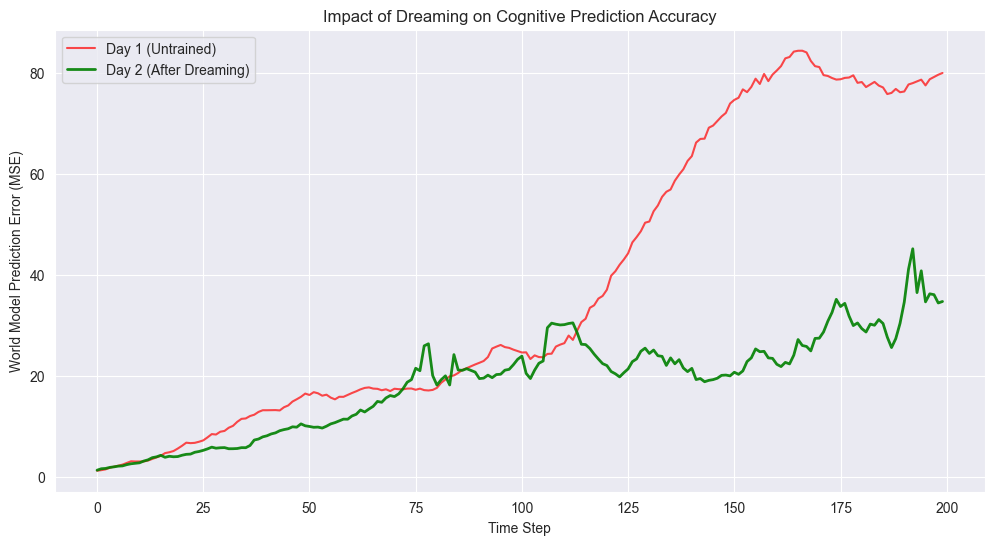

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(prediction_errors_day1, label='Day 1 (Untrained)', alpha=0.7, color='red')
plt.plot(prediction_errors_day2, label='Day 2 (After Dreaming)', alpha=0.9, color='green', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('World Model Prediction Error (MSE)')
plt.title('Impact of Dreaming on Cognitive Prediction Accuracy')
plt.legend()
plt.show()